In [1]:
# %pip install gdown

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
from tqdm.notebook import tqdm
from dataclasses import dataclass



libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [3]:
device = 'cuda:0'

@dataclass
class config:
    # data params
    batch_size = 64
    # optim params
    lr = 1e-3
    weight_decay = 0
    n_gradient_accumulation_steps = 1
    max_grad_norm = 1.0
    # logging
    log_every_n_grad_steps = 512

# Load data

In [4]:
# # Donwload the sample dataset 

# import gdown
# url = 'https://drive.google.com/file/d/1-RQzMIX4yzOYcHRnc-5K6B98eR2dypz6/view?usp=sharing'
# output = 'data/'
# gdown.download(url, output, quiet=False, fuzzy=True)

In [5]:
import safetensors
import pathlib
import os 
import matplotlib.pyplot as plt

path_data = pathlib.Path("data/clf_features_20_50.safetensors")
data = safetensors.safe_open(path_data, framework='pt')
X, y = data.get_tensor('x_50'), data.get_tensor('y')
print(X.shape, y.shape)
print(f'Unique vals in y: {y.unique()}')

torch.Size([1272821, 512]) torch.Size([1272821])
Unique vals in y: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=torch.uint8)


In [6]:
test_ratio = 0.01
split_id_train = int(len(X) * (1-test_ratio))

X_train, X_eval = X[:split_id_train], X[split_id_train:]
y_train, y_eval = y[:split_id_train], y[split_id_train:]

train_loader = DataLoader(
    dataset=X_train,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=False,
    drop_last=True
)
eval_loader = DataLoader(
    dataset=X_eval, 
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)

# What the '0' is for - the one that is dropped in the LESS paper when acquiring 2D maps

[ 0  1  2  3  8  9 10 14 17 18]


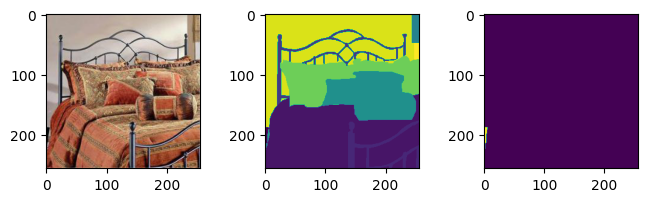

[ 1  3  6 10 11 12 15 16 17 23]


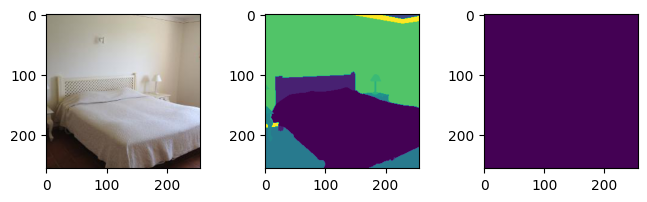

[ 0  1  2  3  5  8 10 11 12 13 17 22 23 25 28]


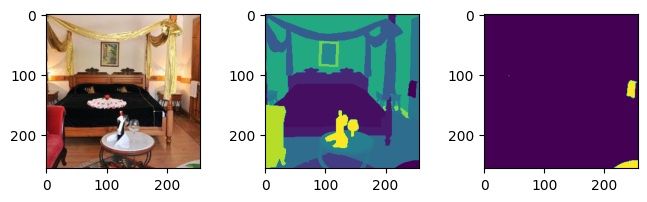

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 22 25]


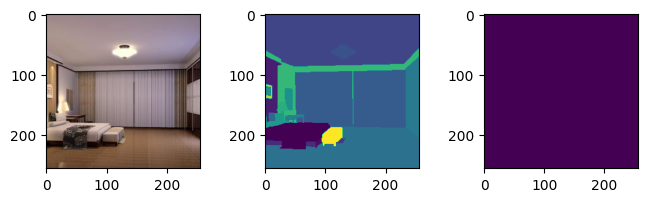

In [7]:
files_img_dataset = 'diffusion-dict-learn/datasets/bedroom_28/real/test'
uniques_filename = list(set([name_.split('.')[0] for name_ in os.listdir(files_img_dataset)]))

num_iter = 4
for filename in uniques_filename[15:15+num_iter]:
    file_mask = pathlib.Path(files_img_dataset) / f"{filename}.npy"
    img_mask = np.load(file_mask)    
    file_png = pathlib.Path(files_img_dataset) / f"{filename}.png"
    img_png = plt.imread(file_png)

    # Unique classes on the mask
    print(np.unique(img_mask))

    f, axs = plt.subplots(1,3, figsize=(8,2))
    axs[0].imshow(img_png)
    axs[1].imshow(img_mask)
    axs[2].imshow(img_mask==0)
    # plt.axes(False)
    plt.show()

> 0 label seems to be reserved for others

# SAE training

Starting with more vanilla SAE w/o top-k or JumpRelu

> Taken from https://github.com/ApolloResearch/e2e_sae/blob/main/e2e_sae/models/sparsifiers.py

In [8]:
import torch
import torch.nn.functional as F
from torch import nn

class SAE(nn.Module):
    """
    Sparse AutoEncoder
    """

    def __init__(
        self, input_size: int, n_dict_components: int, init_decoder_orthogonal: bool = True
    ):
        """Initialize the SAE.

        Args:
            input_size: Dimensionality of input data
            n_dict_components: Number of dictionary components
            init_decoder_orthogonal: Initialize the decoder weights to be orthonormal
        """

        super().__init__()
        # self.encoder[0].weight has shape: (n_dict_components, input_size)
        # self.decoder.weight has shape:    (input_size, n_dict_components)

        self.encoder = nn.Sequential(nn.Linear(input_size, n_dict_components, bias=True), nn.ReLU())
        self.decoder = nn.Linear(n_dict_components, input_size, bias=True)
        self.n_dict_components = n_dict_components
        self.input_size = input_size

        if init_decoder_orthogonal:
            # Initialize so that there are n_dict_components orthonormal vectors
            self.decoder.weight.data = nn.init.orthogonal_(self.decoder.weight.data.T).T

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Pass input through the encoder and normalized decoder."""
        h = self.encoder(x)
        x_hat = F.linear(h, self.dict_elements, bias=self.decoder.bias)
        return x_hat, h

    @property
    def dict_elements(self):
        """Dictionary elements are simply the normalized decoder weights."""
        return F.normalize(self.decoder.weight, dim=0)

    @property
    def device(self):
        return next(self.parameters()).device

## Loss

In [9]:
class SparsityLoss():
    def __init__(self):
        self.p_norm: float = 1.0

    def calc_loss(self, h, dense_dim: int):
        """Calculate the sparsity loss.
        Note that we divide by the dimension of the input to the SAE. This helps with using the same
        hyperparameters across different model sizes (input dimension is more relevant than the c
        dimension for Lp loss).
        Args:
            h: The activations after the non-linearity in the SAE.
            dense_dim: The dimension of the input to the SAE. Used to normalize the loss.
        Returns:
            The L_p norm of the activations.
        """
        return torch.norm(h, p=self.p_norm, dim=-1).mean() / dense_dim
    
class ReconstructionLoss():
    def __init__(self):
        pass
    
    def calc_loss(
        self, z, z_hat
    ):
        """Calculate the MSE between the input and orig."""
        return F.mse_loss(z, z_hat)
    
class SAELoss():
    def __init__(self, coef_sparse):
        self.rec_loss = ReconstructionLoss()
        self.sparse_loss = SparsityLoss()
        self.coef_sparse = coef_sparse
        
    def calc_loss(
        self, z, z_hat, h
    ):
        """
        Calculate the loss (Sparsity+Reconstr*corf).
            Sparsity on `h`
            Reconstruction b/w z and z_hat
        """
        dense_dim = z.size(-1)
        
        loss_rec = self.rec_loss.calc_loss(z, z_hat)
        loss_sparse = self.sparse_loss.calc_loss(h, dense_dim=dense_dim)
        loss_val = loss_rec + self.coef_sparse*loss_sparse
        
        dict_loss_info = {'rec': loss_rec.detach().cpu().item(), 'sparse': loss_sparse.detach().cpu().item(), 'coef_sparse': self.coef_sparse}
        return loss_val, dict_loss_info

### Train loop

In [10]:
n_batches = len(train_loader)
dense_dim = 512
config.n_epochs = 5

sae_loss = SAELoss(coef_sparse=0.001)
model = SAE(input_size=dense_dim, n_dict_components=dense_dim*30).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = None

# logging 
dict_logs = {}

total_samples = 0
grad_updates = 0
# samples_since_act_frequency_collection = 0

for epoch in range(config.n_epochs):
    for batch_idx, batch in tqdm(enumerate(train_loader), total=n_batches, desc="Steps"):
        # dense_embs [bs, dense_dim]
        # dense_dim = 512 in LESS paper
        dense_embs = batch.to(device=device)

        total_samples = total_samples + dense_embs.shape[0]
        # samples_since_act_frequency_collection += dense_embs.shape[0]

        is_grad_step: bool = (batch_idx + 1) % config.n_gradient_accumulation_steps == 0

        # # Note that is_last_batch will always be False for iterable datasets with n_samples=None. In
        # # that case, we will never know when the final batch is reached.
        # is_last_batch: bool = n_batches is not None and batch_idx == n_batches - 1
        # is_eval_step: bool = config.eval_every_n_samples is not None and (
        #     (batch_idx == 0)
        #     or total_samples - total_samples_at_last_eval >= config.eval_every_n_samples
        #     or is_last_batch
        # )
        # is_collect_act_frequency_step: bool = config.collect_act_frequency_every_n_samples > 0 and (
        #     batch_idx == 0
        #     or (
        #         samples_since_act_frequency_collection
        #         >= config.collect_act_frequency_every_n_samples
        #     )
        # )
        is_log_step: bool = (
            batch_idx == 0
            or (is_grad_step and (grad_updates + 1) % config.log_every_n_grad_steps == 0)
            # or is_eval_step
            # or is_last_batch
        )
        # is_save_model_step: bool = save_dir is not None and (
        #     (
        #         config.save_every_n_samples
        #         and total_samples - total_samples_at_last_save >= config.save_every_n_samples
        #     )
        #     or is_last_batch
        # )

        x_hat, h = model(dense_embs)

        loss, dict_loss_info = sae_loss.calc_loss(dense_embs, x_hat, h)

        loss = loss / config.n_gradient_accumulation_steps
        loss.backward()

        if is_grad_step:
            if config.max_grad_norm is not None:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), config.max_grad_norm
                ).item()
            optimizer.step()
            optimizer.zero_grad()
            grad_updates += 1
            if scheduler is not None:
                scheduler.step()

    #     if is_collect_act_frequency_step and act_frequency_metrics is None:
    #         # Start collecting activation frequency metrics for next config.act_frequency_n_tokens
    #         act_frequency_metrics = ActFrequencyMetrics(
    #             dict_sizes={
    #                 hook_pos: new_act_pos.c.shape[-1]
    #                 for hook_pos, new_act_pos in new_acts.items()
    #                 if isinstance(new_act_pos, SAEActs)
    #             },
    #             device=device,
    #         )
    #         samples_since_act_frequency_collection = 0

    #     if act_frequency_metrics is not None:
    #         act_frequency_metrics.update_dict_el_frequencies(
    #             new_acts, batch_tokens=tokens.shape[0] * tokens.shape[1]
    #         )
    #         if act_frequency_metrics.tokens_used >= config.act_frequency_n_tokens:
    #             # Finished collecting activation frequency metrics
    #             metrics = act_frequency_metrics.collect_for_logging(
    #                 log_wandb_histogram=config.wandb_project is not None
    #             )
    #             metrics["total_tokens"] = total_tokens
    #             if config.wandb_project:
    #                 # TODO: Log when not using wandb too
    #                 wandb.log(metrics, step=total_samples)
    #             act_frequency_metrics = None
    #             samples_since_act_frequency_collection = 0

        if is_log_step:
            tqdm.write(
                f"Samples {total_samples:08d} Batch_idx {batch_idx:06d} GradUpdates {grad_updates:06d} "
                f"MSE:{dict_loss_info['rec']/config.n_gradient_accumulation_steps:.5f}, "
                f"Sparsity:{dict_loss_info['sparse']*dict_loss_info['coef_sparse']/config.n_gradient_accumulation_steps:.5f}"
            )

            for k, v in dict_loss_info.items():
                if k not in dict_logs:
                    dict_logs[k] = []
                dict_logs[k].append(v)
    #         if config.wandb_project:
    #             log_info = {
    #                 "loss": loss.item(),
    #                 "grad_updates": grad_updates,
    #                 "total_tokens": total_tokens,
    #                 "lr": optimizer.param_groups[0]["lr"],
    #             }
    #             log_info.update({k: v.item() for k, v in loss_dict.items()})
    #             if grad_norm is not None:
    #                 log_info["grad_norm"] = grad_norm  # Norm of grad before clipping

    #             sparsity_metrics = calc_sparsity_metrics(new_acts=new_acts)
    #             log_info.update(sparsity_metrics)

    #             if new_logits is not None:
    #                 train_output_metrics = calc_output_metrics(
    #                     tokens=tokens,
    #                     orig_logits=orig_logits.detach().clone(),
    #                     new_logits=new_logits.detach().clone(),
    #                 )
    #                 log_info.update(train_output_metrics)

    #             if is_eval_step:
    #                 eval_metrics = evaluate(
    #                     config=config, model=model, device=device, cache_positions=cache_positions
    #                 )
    #                 total_samples_at_last_eval = total_samples
    #                 log_info.update(eval_metrics)

    #             wandb.log(log_info, step=total_samples)

    #     if is_save_model_step:
    #         assert save_dir is not None
    #         total_samples_at_last_save = total_samples
    #         save_module(
    #             config_dict=config.model_dump(mode="json"),
    #             save_dir=save_dir,
    #             module=model.saes,
    #             model_filename=f"samples_{total_samples}.pt",
    #             config_filename="final_config.yaml",
    #         )
    #         if config.wandb_project:
    #             wandb.save(
    #                 str(save_dir / f"samples_{total_samples}.pt"), policy="now", base_path=save_dir
    #             )

        # if is_last_batch:
        #     break

Steps:   0%|          | 0/19688 [00:00<?, ?it/s]

Samples 00000064 Batch_idx 000000 GradUpdates 000001 MSE:118.78633, Sparsity:0.03056
Samples 00032768 Batch_idx 000511 GradUpdates 000512 MSE:1.60896, Sparsity:0.00214
Samples 00065536 Batch_idx 001023 GradUpdates 001024 MSE:0.64218, Sparsity:0.00364
Samples 00098304 Batch_idx 001535 GradUpdates 001536 MSE:0.27236, Sparsity:0.00522
Samples 00131072 Batch_idx 002047 GradUpdates 002048 MSE:0.17327, Sparsity:0.00587
Samples 00163840 Batch_idx 002559 GradUpdates 002560 MSE:0.19713, Sparsity:0.00592
Samples 00196608 Batch_idx 003071 GradUpdates 003072 MSE:2.70235, Sparsity:0.00589
Samples 00229376 Batch_idx 003583 GradUpdates 003584 MSE:0.49898, Sparsity:0.00582
Samples 00262144 Batch_idx 004095 GradUpdates 004096 MSE:0.20326, Sparsity:0.00600
Samples 00294912 Batch_idx 004607 GradUpdates 004608 MSE:0.18079, Sparsity:0.00567
Samples 00327680 Batch_idx 005119 GradUpdates 005120 MSE:0.14878, Sparsity:0.00618
Samples 00360448 Batch_idx 005631 GradUpdates 005632 MSE:0.14193, Sparsity:0.00643
Sa

Steps:   0%|          | 0/19688 [00:00<?, ?it/s]

Samples 01260096 Batch_idx 000000 GradUpdates 019689 MSE:0.09665, Sparsity:0.00647
Samples 01277952 Batch_idx 000279 GradUpdates 019968 MSE:0.11810, Sparsity:0.00651
Samples 01310720 Batch_idx 000791 GradUpdates 020480 MSE:0.09396, Sparsity:0.00644
Samples 01343488 Batch_idx 001303 GradUpdates 020992 MSE:0.10002, Sparsity:0.00682
Samples 01376256 Batch_idx 001815 GradUpdates 021504 MSE:0.09387, Sparsity:0.00662
Samples 01409024 Batch_idx 002327 GradUpdates 022016 MSE:0.09865, Sparsity:0.00688
Samples 01441792 Batch_idx 002839 GradUpdates 022528 MSE:0.08695, Sparsity:0.00683
Samples 01474560 Batch_idx 003351 GradUpdates 023040 MSE:0.10801, Sparsity:0.00674
Samples 01507328 Batch_idx 003863 GradUpdates 023552 MSE:0.10962, Sparsity:0.00671
Samples 01540096 Batch_idx 004375 GradUpdates 024064 MSE:0.09448, Sparsity:0.00667
Samples 01572864 Batch_idx 004887 GradUpdates 024576 MSE:0.09757, Sparsity:0.00675
Samples 01605632 Batch_idx 005399 GradUpdates 025088 MSE:0.09593, Sparsity:0.00633
Samp

Steps:   0%|          | 0/19688 [00:00<?, ?it/s]

Samples 02520128 Batch_idx 000000 GradUpdates 039377 MSE:0.08159, Sparsity:0.00626
Samples 02523136 Batch_idx 000047 GradUpdates 039424 MSE:0.07031, Sparsity:0.00656
Samples 02555904 Batch_idx 000559 GradUpdates 039936 MSE:0.05799, Sparsity:0.00696
Samples 02588672 Batch_idx 001071 GradUpdates 040448 MSE:0.08953, Sparsity:0.00690
Samples 02621440 Batch_idx 001583 GradUpdates 040960 MSE:0.06865, Sparsity:0.00650
Samples 02654208 Batch_idx 002095 GradUpdates 041472 MSE:0.07567, Sparsity:0.00673
Samples 02686976 Batch_idx 002607 GradUpdates 041984 MSE:0.08500, Sparsity:0.00690
Samples 02719744 Batch_idx 003119 GradUpdates 042496 MSE:0.08096, Sparsity:0.00677
Samples 02752512 Batch_idx 003631 GradUpdates 043008 MSE:0.06446, Sparsity:0.00677
Samples 02785280 Batch_idx 004143 GradUpdates 043520 MSE:0.06650, Sparsity:0.00678
Samples 02818048 Batch_idx 004655 GradUpdates 044032 MSE:0.08794, Sparsity:0.00679
Samples 02850816 Batch_idx 005167 GradUpdates 044544 MSE:0.06269, Sparsity:0.00714
Samp

Steps:   0%|          | 0/19688 [00:00<?, ?it/s]

Samples 03780160 Batch_idx 000000 GradUpdates 059065 MSE:0.04623, Sparsity:0.00698
Samples 03801088 Batch_idx 000327 GradUpdates 059392 MSE:0.05030, Sparsity:0.00689
Samples 03833856 Batch_idx 000839 GradUpdates 059904 MSE:0.05834, Sparsity:0.00676
Samples 03866624 Batch_idx 001351 GradUpdates 060416 MSE:0.07514, Sparsity:0.00667
Samples 03899392 Batch_idx 001863 GradUpdates 060928 MSE:0.05748, Sparsity:0.00693
Samples 03932160 Batch_idx 002375 GradUpdates 061440 MSE:0.06052, Sparsity:0.00698
Samples 03964928 Batch_idx 002887 GradUpdates 061952 MSE:0.08407, Sparsity:0.00691
Samples 03997696 Batch_idx 003399 GradUpdates 062464 MSE:0.03989, Sparsity:0.00677
Samples 04030464 Batch_idx 003911 GradUpdates 062976 MSE:0.06989, Sparsity:0.00676
Samples 04063232 Batch_idx 004423 GradUpdates 063488 MSE:0.05532, Sparsity:0.00665
Samples 04096000 Batch_idx 004935 GradUpdates 064000 MSE:0.05234, Sparsity:0.00688
Samples 04128768 Batch_idx 005447 GradUpdates 064512 MSE:0.06019, Sparsity:0.00678
Samp

Steps:   0%|          | 0/19688 [00:00<?, ?it/s]

Samples 05040192 Batch_idx 000000 GradUpdates 078753 MSE:0.06136, Sparsity:0.00700
Samples 05046272 Batch_idx 000095 GradUpdates 078848 MSE:0.07106, Sparsity:0.00694
Samples 05079040 Batch_idx 000607 GradUpdates 079360 MSE:0.04213, Sparsity:0.00684
Samples 05111808 Batch_idx 001119 GradUpdates 079872 MSE:0.04399, Sparsity:0.00676
Samples 05144576 Batch_idx 001631 GradUpdates 080384 MSE:0.04644, Sparsity:0.00697
Samples 05177344 Batch_idx 002143 GradUpdates 080896 MSE:0.05919, Sparsity:0.00662
Samples 05210112 Batch_idx 002655 GradUpdates 081408 MSE:0.04456, Sparsity:0.00675
Samples 05242880 Batch_idx 003167 GradUpdates 081920 MSE:0.04796, Sparsity:0.00696
Samples 05275648 Batch_idx 003679 GradUpdates 082432 MSE:0.04378, Sparsity:0.00691
Samples 05308416 Batch_idx 004191 GradUpdates 082944 MSE:0.05153, Sparsity:0.00701
Samples 05341184 Batch_idx 004703 GradUpdates 083456 MSE:0.04902, Sparsity:0.00711
Samples 05373952 Batch_idx 005215 GradUpdates 083968 MSE:0.03630, Sparsity:0.00696
Samp

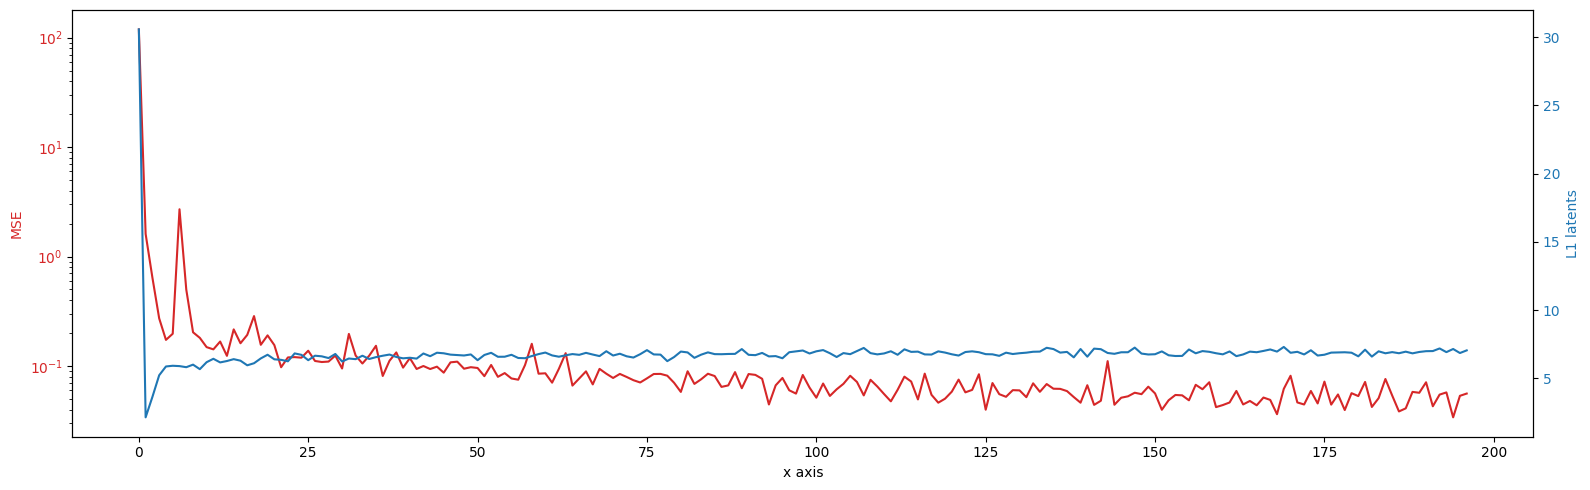

In [14]:
rec_loss_list = dict_logs['rec']
sparse_loss_list = dict_logs['sparse']

fig, ax1 = plt.subplots(figsize=(16,5))

color = 'tab:red'
ax1.set_xlabel('x axis')
ax1.set_ylabel('MSE', color=color)
ax1.plot(rec_loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('L1 latents', color=color)  # we already handled the x-label with ax1
ax2.plot(sparse_loss_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_yscale('log')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Match latent activations and GT masks

In [15]:
y_eval.shape

torch.Size([12729])

In [24]:
model.eval()

latents_list = []
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(eval_loader), total=len(eval_loader), desc="Steps"):
        dense_embs = batch
        x_hat, h = model(dense_embs.to(device))
        latents_list.append(h.detach().cpu())

Steps:   0%|          | 0/199 [00:00<?, ?it/s]

In [25]:
latents_eval = torch.vstack(latents_list) # stack along the batch dim
latents_eval.shape

torch.Size([12729, 15360])

In [26]:
y_eval.unique()

tensor([ 1,  3,  9, 14, 28], dtype=torch.uint8)

In [63]:
acts_on_label.shape

torch.Size([15360])

In [82]:
dict_label_topklatents = {}
k = 5

for y_label in y_eval.unique():
    y_mask = y_eval == y_label
    
    # print(y_mask.unsqueeze(1).shape)
    
    # Leave only latents that overlap with the considered label
    latents_masked = latents_eval * y_mask.unsqueeze(1)
    
    # print(latents_eval)
    # print(latents_masked)
    
    # print(latents_masked.shape)
    acts_on_label = latents_masked.sum(0)
    
    # print(acts_on_label.shape)
    # plt.hist(acts_on_label, bins=100)
    # plt.semilogy()
    # plt.show()
    
    label_topk = acts_on_label.topk(k=5)
    dict_label_topklatents[y_label.item()] = label_topk
    
    # Check intersection % for top k latents
    print(f"Intersection with Mask and IoU check for label: {y_label}")
    for idx_latent in label_topk.indices:
        top_latent_activaiton_binary = latents_eval[:, idx_latent] > 0
        intersection_with_label = (y_mask * top_latent_activaiton_binary).sum() / y_mask.sum()
        iou = (y_mask * top_latent_activaiton_binary).sum() / (y_mask+top_latent_activaiton_binary).sum()
        print(f"{idx_latent:06d}| IwM:{intersection_with_label.item():.03f} | IoU:{iou.item():.03f}")    

Intersection with Mask and IoU check for label: 1
006982| IwM:0.999 | IoU:0.549
006335| IwM:0.994 | IoU:0.547
008829| IwM:1.000 | IoU:0.549
005733| IwM:0.996 | IoU:0.548
013595| IwM:0.981 | IoU:0.543
Intersection with Mask and IoU check for label: 3
006982| IwM:1.000 | IoU:0.164
006335| IwM:0.992 | IoU:0.163
008829| IwM:1.000 | IoU:0.164
005733| IwM:0.995 | IoU:0.164
013595| IwM:0.983 | IoU:0.163
Intersection with Mask and IoU check for label: 9
006982| IwM:0.997 | IoU:0.052
008829| IwM:1.000 | IoU:0.052
006335| IwM:0.994 | IoU:0.052
005733| IwM:0.989 | IoU:0.051
013595| IwM:0.983 | IoU:0.052
Intersection with Mask and IoU check for label: 14
006982| IwM:0.999 | IoU:0.099
006335| IwM:0.993 | IoU:0.099
008829| IwM:1.000 | IoU:0.099
013595| IwM:0.986 | IoU:0.099
005733| IwM:0.994 | IoU:0.099
Intersection with Mask and IoU check for label: 28
006982| IwM:0.999 | IoU:0.137
006335| IwM:0.992 | IoU:0.137
008829| IwM:1.000 | IoU:0.137
005733| IwM:0.995 | IoU:0.137
013595| IwM:0.976 | IoU:0.13

In [68]:
dict_label_topklatents

{1: torch.return_types.topk(
 values=tensor([141216.3906, 133717.9844, 133428.0781, 120668.8438, 115029.6250]),
 indices=tensor([ 6982,  6335,  8829,  5733, 13595])),
 3: torch.return_types.topk(
 values=tensor([42358.4922, 40737.7969, 39234.6875, 35032.0898, 34378.8008]),
 indices=tensor([ 6982,  6335,  8829,  5733, 13595])),
 9: torch.return_types.topk(
 values=tensor([13318.5986, 12664.7080, 12514.9941, 11135.8555, 11036.9980]),
 indices=tensor([ 6982,  8829,  6335,  5733, 13595])),
 14: torch.return_types.topk(
 values=tensor([24880.9844, 24468.5195, 23805.1855, 21434.3457, 21352.2871]),
 indices=tensor([ 6982,  6335,  8829, 13595,  5733])),
 28: torch.return_types.topk(
 values=tensor([35044.5078, 33567.9570, 32752.3398, 29446.3340, 28714.1348]),
 indices=tensor([ 6982,  6335,  8829,  5733, 13595]))}